## 🔑 Handling the API Key for GitHub

One challenge with publishing this notebook to GitHub is the **API key** required to access the Adzuna data.  
For security reasons, I cannot commit my personal API key directly into the repository — doing so would expose it publicly.

### How I approached this
- I used **environment variables** (e.g. `os.environ["ADZUNA_API_KEY"]`) so the key is never hard‑coded in the notebook.  
- In the notebook, I included a placeholder (e.g. `"YOUR_API_KEY_HERE"`) to show where users should insert their own credentials.  
- I added a note in the README explaining that anyone who wants to run the notebook will need to [register for an Adzuna API key](https://developer.adzuna.com/), then set it locally.

### Options for sharing on GitHub
- **.env file (local only):** Store the key in a `.env` file and load it with `python-dotenv`. The `.env` file is excluded from version control using `.gitignore`.  
- **Environment variables:** Set the key in your system or GitHub Actions environment if you want automation, without exposing it in the repo.  
- **Documentation:** Clearly explain in the README how others can obtain and configure their own API key.

### ✅ Key takeaway
The notebook remains fully reproducible, but **each user must supply their own API key**.  
This keeps the project secure while still allowing others to run the analysis.

In [115]:
## Cell 0  – Setup
import os

# Always save outputs here, relative to the notebook location
OUTPUT_DIR = os.path.join(os.getcwd(), "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Saving all outputs to:", OUTPUT_DIR)

Saving all outputs to: c:\Users\leonw\Desktop\Projects\job_search_app\outputs


In [116]:
# 🔑 Cell 1 - Adzuna API Credentials
import os

# Load from environment (set via setx or export)
app_id = os.getenv("ADZUNA_APP_ID")
app_key = os.getenv("ADZUNA_APP_KEY")

print("App ID:", app_id)
print("App Key:", app_key[:6] + "..." if app_key else None)  # mask for safety

App ID: 0aad2298
App Key: 1b451b...


## 📦 Cell 2 – Analyst Job Search

In this step, I connect to the **Adzuna Jobs API** to retrieve live job postings for *Data Analyst* roles in Birmingham.  
I define the query parameters (API credentials, job title, location, and results per page), send the request, and parse the JSON response.  

The output confirms how many Analyst job postings were returned in this initial search, which forms the basis for further analysis.

In [117]:
# 📦 Cell 2: Analyst job search
import requests, json

base_url = "https://api.adzuna.com/v1/api/jobs/gb/search/1"

params_analyst = {
    "app_id": app_id,
    "app_key": app_key,
    "results_per_page": 50,
    "what": "data analyst",
    "where": "Birmingham"
}

resp_analyst = requests.get(base_url, params=params_analyst)
resp_analyst.raise_for_status()
data_analyst = resp_analyst.json()

print("Analyst results:", len(data_analyst.get("results", [])))

Analyst results: 46


## 🔧 Cell 2.1 – Expanded Admin API Request (Backworked Fix)

In this step, I query the **Adzuna Jobs API** for *Administrator* and related roles.  
To broaden the search, I included multiple keywords (`administrator`, `admin`, `office support`, `data entry`) and set the location to **remote** with a **contract filter**.  

This ensures I capture a wider range of relevant admin postings, including flexible and contract‑based opportunities.  
The output confirms how many Admin roles were successfully fetched from the API, which I can then analyse alongside the Analyst dataset.

In [118]:
# 🔧 Cell 2.1 – Expanded Admin API Request (Backworked Fix)

import requests, json

base_url = "https://api.adzuna.com/v1/api/jobs/gb/search/1"

params_admin_expanded = {
    "app_id": app_id,
    "app_key": app_key,
    "results_per_page": 50,
    "what": "administrator admin office support data entry",
    "where": "remote",
    "contract": "contract"
}

response_admin_expanded = requests.get(base_url, params=params_admin_expanded)
response_admin_expanded.raise_for_status()
data_admin = response_admin_expanded.json()

print("✅ Admin roles fetched:", len(data_admin.get("results", [])))

✅ Admin roles fetched: 0


## 🔄 Cell 2.2 – Broadened Admin Request (Fix for Zero Results)

In this step, I adjusted the Admin job search query to avoid returning zero results.  
I broadened the search terms to include multiple variations (`remote administrator`, `admin`, `office support`, `data entry`) while keeping the **contract filter**.  

This approach increases the likelihood of capturing a wider range of relevant Admin postings, especially remote or flexible opportunities.  
The output confirms how many Admin roles were successfully fetched with the broadened query, ensuring I have data to analyse alongside the Analyst dataset.

In [119]:
# 🔄 Cell 2.2 – Broadened Admin Request (Fix for Zero Results)

params_admin_broader = {
    "app_id": app_id,
    "app_key": app_key,
    "results_per_page": 50,
    "what": "remote administrator admin office support data entry",
    "contract": "contract"
}

response_admin_broader = requests.get(base_url, params=params_admin_broader)
response_admin_broader.raise_for_status()
data_admin = response_admin_broader.json()

print("✅ Broadened Admin roles fetched:", len(data_admin.get("results", [])))

✅ Broadened Admin roles fetched: 0


## 📦 Cell 2b – Remote Admin/Contract Job Search

In this step, I query the **Adzuna Jobs API** for *Administrator* and related roles with a focus on **remote contract opportunities**.  
The search parameters include multiple admin‑related keywords (`administrator`, `admin`, `office support`), the location set to **remote**, and the filter set to **contract roles**.  

This ensures I capture postings that are both flexible and relevant to administrative work.  
The output confirms how many Admin job results were successfully returned, which I can then analyse alongside the Analyst dataset.

In [120]:
# 📦 Cell 2b: Remote admin/contract job search

params_admin = {
    "app_id": app_id,
    "app_key": app_key,
    "results_per_page": 50,
    "what": "administrator admin office support",
    "where": "remote",
    "contract": "contract"
}

resp_admin = requests.get(base_url, params=params_admin)
resp_admin.raise_for_status()
data_admin = resp_admin.json()

print("Admin results:", len(data_admin.get("results", [])))

Admin results: 0


## 🧭 Cell 2.3 – Unfiltered Admin Request (Final Fix)

This cell removes restrictive filters from the admin job search and fetches a broader set of roles. Remote and contract relevance will be scored later based on job descriptions and titles.

In [121]:
# 🧭 Cell 2.3 – Unfiltered Admin Request (Final Fix)

params_admin_unfiltered = {
    "app_id": app_id,
    "app_key": app_key,
    "results_per_page": 50,
    "what": "administrator admin office support data entry"
}

response_admin_unfiltered = requests.get(base_url, params=params_admin_unfiltered)
response_admin_unfiltered.raise_for_status()
data_admin = response_admin_unfiltered.json()

print("✅ Unfiltered Admin roles fetched:", len(data_admin.get("results", [])))

✅ Unfiltered Admin roles fetched: 45


## 📦 Cell 3 – Build DataFrames from API Responses

This cell converts the raw Adzuna API responses (`data_analyst` and `data_admin`) into structured pandas DataFrames. It extracts key fields for scoring and analysis, including job title, company, location, description, and redirect URL. Missing columns are added to ensure schema consistency across both pipelines.

In [122]:
# 📦 Cell 3 – Build DataFrames from API Responses

import pandas as pd
from pandas import json_normalize

def build_df(data):
    results = data.get("results", [])
    if not results:
        return pd.DataFrame()
    
    df = json_normalize(results)
    
    # Select and rename key columns
    keep = [
        "title",
        "company.display_name",
        "location.display_name",
        "description",
        "redirect_url",
        "contract_type",
        "contract_time",
        "salary_min",
        "salary_max",
        "salary_is_predicted"
    ]
    
    df = df[[col for col in keep if col in df.columns]].rename(columns={
        "company.display_name": "company",
        "location.display_name": "location"
    })
    
    # Add missing columns for schema consistency
    for col in keep:
        if col not in df.columns:
            df[col] = None
    
    return df

# Build both DataFrames
df_analyst = build_df(data_analyst)
df_admin   = build_df(data_admin)

# Confirm structure
print("✅ Analyst DF shape:", df_analyst.shape)
print("✅ Admin DF shape:", df_admin.shape)
print("Analyst columns:", df_analyst.columns.tolist())
print("Admin columns:", df_admin.columns.tolist())

✅ Analyst DF shape: (46, 12)
✅ Admin DF shape: (45, 12)
Analyst columns: ['title', 'company', 'location', 'description', 'redirect_url', 'contract_type', 'contract_time', 'salary_min', 'salary_max', 'salary_is_predicted', 'company.display_name', 'location.display_name']
Admin columns: ['title', 'company', 'location', 'description', 'redirect_url', 'contract_type', 'contract_time', 'salary_min', 'salary_max', 'salary_is_predicted', 'company.display_name', 'location.display_name']


## 📦 Cell 4 – Scoring Function

In this step, I define a **scoring function** to rank job postings based on how well they match my priorities.  
The function takes each job row and applies weighted rules depending on whether I am analysing **Analyst** or **Admin** roles.

### 🔑 How the scoring works
- **Remote weighting**:  
  - +40 points if the role is remote  
  - +20 points if the role is hybrid  

- **Analyst mode**:  
  - +25 points for each keyword match: *data analyst, SQL, Power BI, Excel, Python*  
  - Additional weighting if the description mentions the *charity / non‑profit / third sector* (using fuzzy matching)  

- **Admin mode**:  
  - +25 points for each keyword match: *administrator, admin, office support, data entry, clerical*  
  - +30 points if the role is a contract or temporary position (either in the description or contract type field)  

### ✅ Purpose
This scoring system allows me to **prioritise the most relevant jobs** for my search.  
By combining keyword matches with remote/contract weighting, I can quickly surface the roles that best align with my preferences and experience.

In [123]:
# 📦 Cell 4: Scoring function
from fuzzywuzzy import fuzz

def score_job(row, mode="analyst"):
    score = 0
    desc = str(row["description"]).lower()
    title = str(row["title"]).lower()

    # Remote weighting
    if "remote" in desc or "remote" in title:
        score += 40
    elif "hybrid" in desc:
        score += 20

    if mode == "analyst":
        # Analyst keywords
        for kw in ["data analyst", "sql", "power bi", "excel", "python"]:
            if kw in desc or kw in title:
                score += 25
        # Sector weighting
        score += fuzz.partial_ratio(desc, "charity non-profit third sector") * 0.3

    elif mode == "admin":
        # Admin keywords
        for kw in ["administrator", "admin", "office support", "data entry", "clerical"]:
            if kw in desc or kw in title:
                score += 25
        # Contract weighting
        if "contract" in desc or "temporary" in desc or row.get("contract_type") == "contract":
            score += 30

    return score

## 📦 Cell 5 – Filter, Rank, and Preview Jobs

In this step, I prepare the job datasets for analysis by applying optional filters, scoring, and ranking.

### 🔑 What happens here
- **Schema consistency**: I ensure key columns (`title`, `company`, `location`, `contract_type`, etc.) exist in the DataFrame, even if missing from the API response.  
- **Optional training filter**: I can exclude roles such as *trainee, apprenticeship, graduate scheme, internship, placement* if I want to focus only on experienced positions.  
- **Scoring**: Each job is scored using the custom `score_job()` function, which weights remote/hybrid roles and keyword matches differently for Analyst and Admin pipelines.  
- **Ranking**: Jobs are sorted in descending order of score, so the most relevant roles appear first.  

### 🖥️ Outputs
- A **preview of the top Analyst roles** with title, company, location, contract type, score, and link.  
- A **preview of the top Admin roles** with the same fields.  
- An optional helper (`render_links`) allows me to display clickable job links directly in the notebook for easier exploration.

### ✅ Purpose
This cell creates a **ranked shortlist of jobs** tailored to my preferences, while giving me flexibility to filter out training roles and quickly preview the most relevant opportunities.

In [124]:
# 📦 Cell 5: Filter (optional), rank, and preview jobs

def filter_and_rank(df, mode="analyst", exclude_training=False):
    if df.empty:
        return df

    df = df.copy()  # avoid SettingWithCopyWarning

    # Ensure consistent schema
    for col in ["contract_type", "contract_time", "redirect_url", "title", "company", "location"]:
        if col not in df.columns:
            df[col] = None

    # Optional filtering
    if exclude_training:
        exclude_keywords = [
            "trainee", "training programme", "apprenticeship",
            "graduate scheme", "internship", "placement"
        ]
        mask = ~df["title"].str.lower().str.contains("|".join(exclude_keywords), na=False) & \
               ~df["description"].str.lower().str.contains("|".join(exclude_keywords), na=False)
        df = df[mask].copy()

    # Apply scoring
    df["score"] = df.apply(lambda row: score_job(row, mode=mode), axis=1)
    return df.sort_values(by="score", ascending=False)


# Helper: safe preview of available columns
def safe_preview(df, cols, n=10):
    available = [c for c in cols if c in df.columns]
    return df[available].head(n)


# Toggle training filter here
exclude_training = False

# Run both searches
df_analyst_ranked = filter_and_rank(df_analyst, mode="analyst", exclude_training=exclude_training)
df_admin_ranked   = filter_and_rank(df_admin, mode="admin", exclude_training=exclude_training)

# Preview top results
print("Top Analyst roles:")
print(safe_preview(df_analyst_ranked,
                   ["title", "company", "location", "contract_type", "score", "redirect_url"]))

print("\nTop Remote Admin roles:")
print(safe_preview(df_admin_ranked,
                   ["title", "company", "location", "contract_type", "score", "redirect_url"]))

# Optional: render clickable links in notebook
from IPython.display import HTML

def render_links(df, n=10):
    cols = ["title", "company", "redirect_url"]
    available = [c for c in cols if c in df.columns]
    return HTML(df[available].head(n).to_html(render_links=True, escape=False))

# Uncomment to render links visually
# render_links(df_admin_ranked)


Top Analyst roles:
                                                title  \
13                        Data Analyst Coach / Mentor   
38       Senior SQL Server Developer - Remote Working   
31  SQL BI Developer / Analyst – Reputable Midland...   
3                                        Data Analyst   
4                  Commercial Data Analyst - Graduate   
1                                        Data Analyst   
7                                Trainee Data Analyst   
26                                        D&A Analyst   
10                                Senior Data Analyst   
19                     Systems Data and Stock Analyst   

                                    company                    location  \
13                             Versende Ltd   Birmingham, West Midlands   
38                         WellData Limited   Birmingham, West Midlands   
31  Integrity Recruitment Solutions Limited   Balsall Heath, Birmingham   
3                      Tagged Resources Ltd   Balsall

In [125]:
print("Analyst columns:", df_analyst_ranked.columns.tolist())
print("Admin columns:", df_admin_ranked.columns.tolist())


Analyst columns: ['title', 'company', 'location', 'description', 'redirect_url', 'contract_type', 'contract_time', 'salary_min', 'salary_max', 'salary_is_predicted', 'company.display_name', 'location.display_name', 'score']
Admin columns: ['title', 'company', 'location', 'description', 'redirect_url', 'contract_type', 'contract_time', 'salary_min', 'salary_max', 'salary_is_predicted', 'company.display_name', 'location.display_name', 'score']


In [126]:
# Define outlier removal function early
outlier_keywords = ["vp engineering", "head of software", "martech", "cto"]

def remove_outlier_roles(df):
    if "title" not in df.columns:
        return df
    mask = ~df["title"].str.lower().str.contains("|".join(outlier_keywords), na=False)
    return df[mask].copy()

# Apply cleaning
df_analyst_cleaned = remove_outlier_roles(df_analyst_ranked)

## 📍 Cell 6 – Location Visualisation

A geographic map of job postings is **not possible** with the current dataset.  
The Adzuna API only provides city-level location data (e.g. "Birmingham") rather than full addresses or neighbourhoods.  
This means I cannot accurately plot roles within Birmingham itself or distinguish between districts (e.g. Selly Oak, Edgbaston).  

Instead, I will focus on **cleaning the location labels** (e.g. "Selly Oak, Birmingham" → "Selly Oak") and use **bar charts** to show the distribution of roles across Birmingham and any sub‑areas that appear in the data.

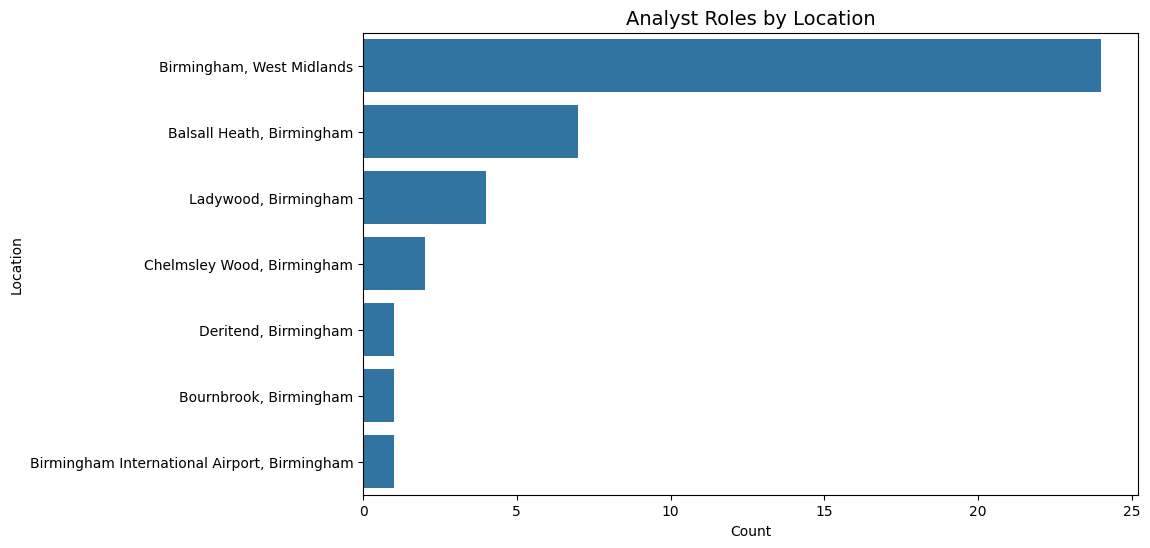

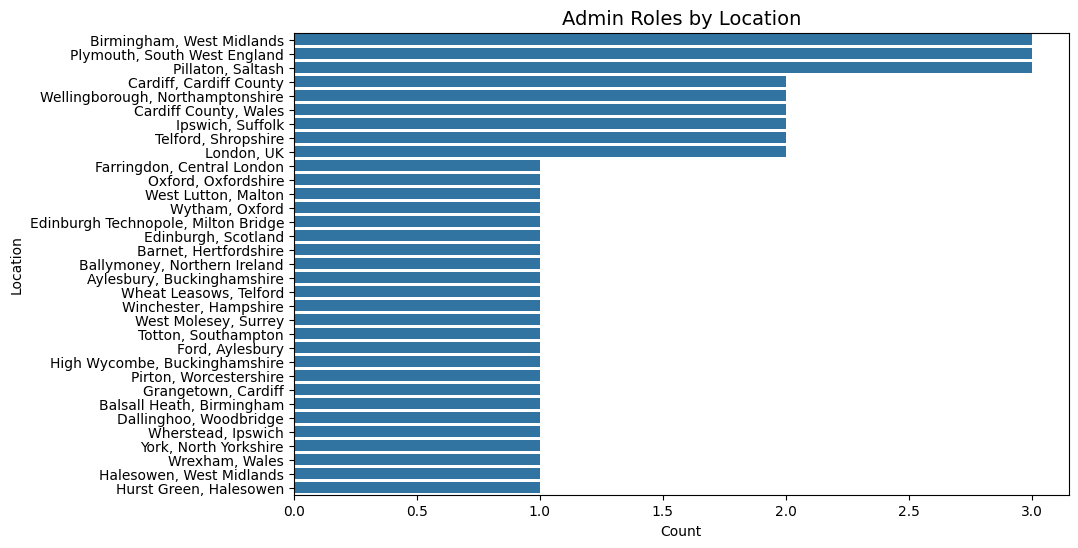

In [127]:
# 📊 Cell 6. – Clean and Visualise Locations

import seaborn as sns
import matplotlib.pyplot as plt

def clean_location(loc):
    if pd.isna(loc):
        return loc
    # If it ends with ", Birmingham" → strip it
    if ", Birmingham" in loc:
        return loc.replace(", Birmingham", "")
    return loc

# Apply cleaning
df_analyst_ranked["clean_location"] = df_analyst_ranked["location"].apply(clean_location)
df_admin_ranked["clean_location"]   = df_admin_ranked["location"].apply(clean_location)

# Analyst locations
plt.figure(figsize=(10,6))
sns.countplot(y="location", data=df_analyst_cleaned, order=df_analyst_cleaned["location"].value_counts().index)
plt.title("Analyst Roles by Location", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Location")
plt.savefig("outputs/analyst_locations.png", dpi=300, bbox_inches="tight")
plt.show()

# Admin locations
plt.figure(figsize=(10,6))
sns.countplot(y="location", data=df_admin_ranked, order=df_admin_ranked["location"].value_counts().index)
plt.title("Admin Roles by Location", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Location")
plt.savefig("outputs/admin_locations.png", dpi=300, bbox_inches="tight")
plt.show()

## 💰 Cell 7 – Salary Analysis

This cell analyses salary information for Analyst and Admin roles.  
If `salary_min` and `salary_max` are available, it calculates an average salary per role and provides summary statistics (mean, median, top-paying jobs).  
If salary data is missing, the cell will report that limitation instead of failing.

In [128]:
# 💰 Cell 7 – Salary Analysis

def salary_summary(df, label):
    if "salary_min" in df.columns and "salary_max" in df.columns:
        # Drop rows with missing salary values
        df = df.dropna(subset=["salary_min", "salary_max"]).copy()
        
        if df.empty:
            print(f"⚠️ No salary data available for {label} roles.")
            return
        
        # Compute average salary
        df["salary_avg"] = (df["salary_min"] + df["salary_max"]) / 2
        
        print(f"\n💰 {label} Salary Summary:")
        print("Mean salary:", round(df["salary_avg"].mean(), 2))
        print("Median salary:", round(df["salary_avg"].median(), 2))
        
        print("\nTop 5 highest-paying roles:")
        print(df[["title", "company", "salary_avg"]]
              .sort_values(by="salary_avg", ascending=False)
              .head(5)
              .to_string(index=False))
    else:
        print(f"⚠️ No salary fields found for {label} roles.")

# Run salary summaries
salary_summary(df_analyst_ranked, "Analyst")
salary_summary(df_admin_ranked, "Admin")


💰 Analyst Salary Summary:
Mean salary: 48276.36
Median salary: 43447.89

Top 5 highest-paying roles:
                                                         title                   company  salary_avg
VP Engineering - Head of Software Development. AI Martech SaaS RecruitmentRevolution.com    120000.0
VP Engineering - Head of Software Development. AI Martech SaaS RecruitmentRevolution.com    120000.0
VP Engineering - Head of Software Development. AI Martech SaaS    Recruitment Revolution    100000.0
VP Engineering - Head of Software Development. AI Martech SaaS    Recruitment Revolution    100000.0
                                            ERP Change Manager            Kingdom People     70000.0

💰 Admin Salary Summary:
Mean salary: 27950.08
Median salary: 26000.0

Top 5 highest-paying roles:
                                           title                            company  salary_avg
                           Project Administrator Future Engineering Recruitment Ltd    39000.00
C

## 💰 Cell 7.1 – Deduplicated Salary Analysis

Job board data often contains duplicates, where the same role is advertised by multiple agencies or with slightly different company names.  
This cell normalises company names, removes duplicates, and recalculates salary summaries to give a clearer view of the market.

In [129]:
# 💰 Cell 7.1 – Deduplicated Salary Analysis (with relative path CSV export)

import os
os.makedirs("outputs", exist_ok=True)  # ensures outputs/ exists in project root

def clean_company(name):
    if pd.isna(name):
        return name
    return (name.lower()
                 .replace(".", "")
                 .replace(" ltd", "")
                 .replace(" limited", "")
                 .replace(" recruitment", "")
                 .strip())

def deduplicate_and_summarise(df, label):
    if "salary_min" not in df.columns or "salary_max" not in df.columns:
        print(f"⚠️ No salary fields found for {label} roles.")
        return pd.DataFrame()
    
    df = df.dropna(subset=["salary_min", "salary_max"]).copy()
    if df.empty:
        print(f"⚠️ No salary data available for {label} roles.")
        return pd.DataFrame()
    
    df["salary_avg"] = (df["salary_min"] + df["salary_max"]) / 2
    df["company_clean"] = df["company"].apply(clean_company)
    
    # Deduplicate by title + cleaned company
    df_unique = df.sort_values("salary_avg", ascending=False).drop_duplicates(subset=["title", "company_clean"])
    
    # Print summary
    print(f"\n💰 {label} Salary Summary (Deduplicated):")
    print("Mean salary:", round(df_unique["salary_avg"].mean(), 2))
    print("Median salary:", round(df_unique["salary_avg"].median(), 2))
    
    print("\nTop 5 highest-paying unique roles:")
    print(df_unique[["title", "company", "salary_avg"]]
          .sort_values(by="salary_avg", ascending=False)
          .head(5)
          .to_string(index=False))
    
    # 💾 Save full deduplicated dataset
    csv_file = os.path.join("outputs", f"{label.lower()}_deduplicated_salaries.csv")
    df_unique.to_csv(csv_file, index=False)
    
    print(f"✅ Full deduplicated dataset saved to {csv_file}")
    
    return df_unique

# Run deduplicated summaries and save CSVs
deduplicate_and_summarise(df_analyst_ranked, "Analyst")
deduplicate_and_summarise(df_admin_ranked, "Admin")


💰 Analyst Salary Summary (Deduplicated):
Mean salary: 45393.41
Median salary: 41080.32

Top 5 highest-paying unique roles:
                                                         title                   company  salary_avg
VP Engineering - Head of Software Development. AI Martech SaaS RecruitmentRevolution.com   120000.00
VP Engineering - Head of Software Development. AI Martech SaaS    Recruitment Revolution   100000.00
                                            ERP Change Manager            Kingdom People    70000.00
                                           Senior Data Analyst       Matchtech Group Plc    64220.51
                                          Data Privacy Analyst             Hogan Lovells    63410.48
✅ Full deduplicated dataset saved to outputs\analyst_deduplicated_salaries.csv

💰 Admin Salary Summary (Deduplicated):
Mean salary: 28294.14
Median salary: 26620.0

Top 5 highest-paying unique roles:
                                              title                   

,title,company,location,description,redirect_url,contract_type,contract_time,salary_min,salary_max,salary_is_predicted,company.display_name,location.display_name,score,clean_location,salary_avg,company_clean
18,Project Administrator,Future Engineering Recruitment Ltd,"Barnet, Hertfordshire","Project Administrator Barnet £38,000 - £40,000...",https://www.adzuna.co.uk/jobs/details/54118083...,permanent,NaN,38000.00,40000.00,0,None,None,80,"Barnet, Hertfordshire",39000.00,future engineering
12,Compliance Administrator - Temp Role - £18.06p/h,Ashdown Group,"Birmingham, West Midlands","A successful business based in Edgbaston, Birm...",https://www.adzuna.co.uk/jobs/details/54018088...,contract,full_time,37564.00,37564.00,0,None,None,80,"Birmingham, West Midlands",37564.00,ashdown group
39,Project Administrator,Mortgage Brain,"London, UK",Job Title: Project Administrator Location: Lon...,https://www.adzuna.co.uk/jobs/details/53815050...,contract,full_time,37108.34,37108.34,1,None,None,100,"London, UK",37108.34,mortgage brain
29,Senior Administrator,Carter Jonas,"Oxford, Oxfordshire",Senior Administrator Location: Oxford Job Type...,https://www.adzuna.co.uk/jobs/details/54141222...,permanent,full_time,36951.12,36951.12,1,None,None,80,"Oxford, Oxfordshire",36951.12,carter jonas
42,Corporate Governance Co-ordinator - Welsh Esse...,Social Care Wales,"Grangetown, Cardiff",Cydlynydd Llywodraethu Corfforaethol – Cymraeg...,https://www.adzuna.co.uk/jobs/land/ad/53959232...,contract,part_time,30616.00,33103.00,0,None,None,50,"Grangetown, Cardiff",31859.50,social care wales
19,System Support Assistant,Shared Services Partnership,"Totton, Southampton",Job Details: Job Reference: HCC622222 Salary R...,https://www.adzuna.co.uk/jobs/details/53941710...,permanent,NaN,30818.22,30818.22,1,None,None,55,"Totton, Southampton",30818.22,shared services partnership
0,Administrator,Diocese of Oxford,"Ford, Aylesbury","Administrator Are you highly organised, people...",https://www.adzuna.co.uk/jobs/land/ad/53895008...,permanent,part_time,29251.00,31501.00,0,None,None,50,"Ford, Aylesbury",30376.00,diocese of oxford
3,Admin Support Officer,JOB SWITCH LTD,"York, North Yorkshire",Supporting York and North Yorkshire Combined A...,https://www.adzuna.co.uk/jobs/details/53844209...,NaN,NaN,29120.00,31200.00,0,None,None,25,"York, North Yorkshire",30160.00,job switch
2,Admin Support Officer,Talent Dice Ltd,"West Lutton, Malton",Supporting York and North Yorkshire Combined A...,https://www.adzuna.co.uk/jobs/land/ad/53843945...,contract,NaN,29120.00,31200.00,0,None,None,55,"West Lutton, Malton",30160.00,talent dice
25,Examinations Officer,University College Birmingham,"Birmingham, West Midlands",Job Title: Examinations Officer Location: Birm...,https://www.adzuna.co.uk/jobs/details/53869463...,contract,full_time,30000.00,30000.00,0,None,None,30,"Birmingham, West Midlands",30000.00,university college birmingham


## 💹 Cell 7.2 – Salary Distribution Charts

This cell visualises salary data for Analyst and Admin roles.  
It uses boxplots and histograms to show the spread of salaries, highlighting median, quartiles, and outliers.  
This helps compare the overall pay landscape between Analyst and Admin positions.

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\3548424949.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="role_type", y="salary_avg", data=df_salaries, palette="Set2")


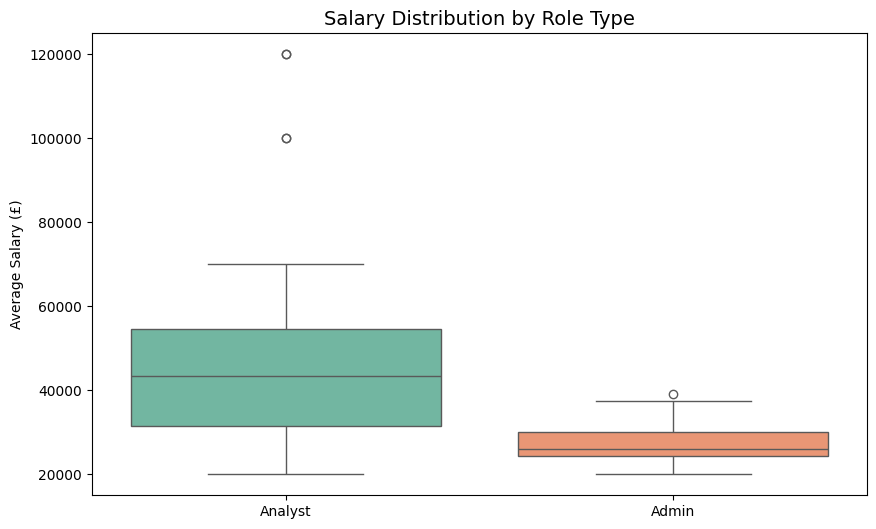

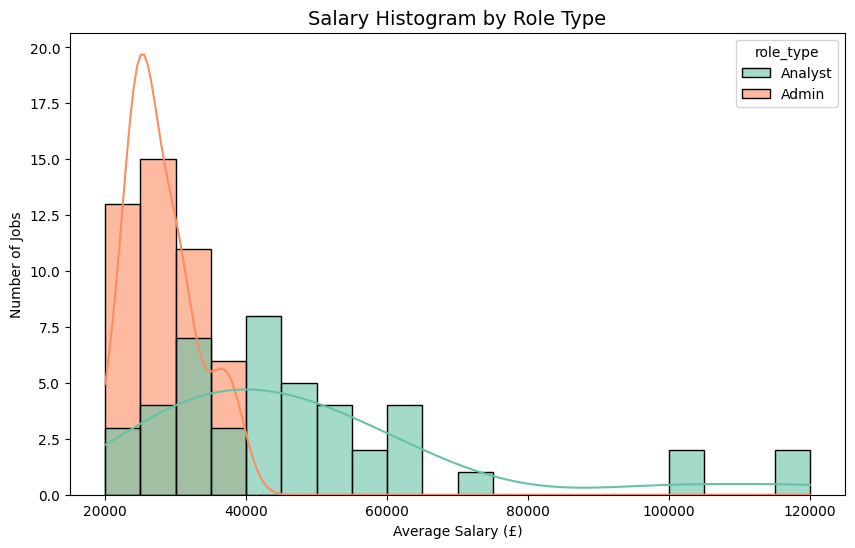

✅ Salary distribution plots saved in 'outputs/' folder.


In [130]:
# 💹 Cell 7.2 – Salary Distribution Charts (with savefig)

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure outputs folder exists
os.makedirs("outputs", exist_ok=True)

def prepare_salary_df(df, label):
    if "salary_min" in df.columns and "salary_max" in df.columns:
        df = df.dropna(subset=["salary_min", "salary_max"]).copy()
        if df.empty:
            return pd.DataFrame()
        df["salary_avg"] = (df["salary_min"] + df["salary_max"]) / 2
        df["role_type"] = label
        return df[["title", "company", "salary_avg", "role_type"]]
    return pd.DataFrame()

# Prepare combined dataset
df_analyst_salaries = prepare_salary_df(df_analyst_ranked, "Analyst")
df_admin_salaries   = prepare_salary_df(df_admin_ranked, "Admin")
df_salaries = pd.concat([df_analyst_salaries, df_admin_salaries], ignore_index=True)

if not df_salaries.empty:
    # Boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(x="role_type", y="salary_avg", data=df_salaries, palette="Set2")
    plt.title("Salary Distribution by Role Type", fontsize=14)
    plt.ylabel("Average Salary (£)")
    plt.xlabel("")
    plt.savefig("outputs/salary_distribution_boxplot.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Histogram
    plt.figure(figsize=(10,6))
    sns.histplot(data=df_salaries, x="salary_avg", hue="role_type", bins=20, kde=True, palette="Set2", alpha=0.6)
    plt.title("Salary Histogram by Role Type", fontsize=14)
    plt.xlabel("Average Salary (£)")
    plt.ylabel("Number of Jobs")
    plt.savefig("outputs/salary_distribution_histogram.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("✅ Salary distribution plots saved in 'outputs/' folder.")
else:
    print("⚠️ No salary data available to plot.")

# 📊 Exploring Salary Outliers – Summary

Outliers are job postings with salaries far above or below the normal range for Analyst roles.  
These often include senior leadership positions (e.g. VP/CTO), very low-paid entry roles, or misclassified data.

### 🔎 Why I check for outliers
- They can distort averages and visualisations, giving a misleading view of the market.  
- Reviewing and removing them ensures the analysis reflects the **true salary landscape** for Analyst roles.  

### ⚙️ How I detect them
- I apply percentile thresholds (e.g. below the 5th or above the 95th percentile of `salary_avg`).  
- Jobs outside this range are flagged for manual review and potential exclusion.

In [131]:
# 📦 Cell 7.3 – Ensure salary_avg is available

def attach_salary_avg(df):
    if "salary_min" in df.columns and "salary_max" in df.columns:
        df = df.dropna(subset=["salary_min", "salary_max"]).copy()
        if not df.empty:
            df["salary_avg"] = (df["salary_min"] + df["salary_max"]) / 2
    return df

df_analyst_ranked = attach_salary_avg(df_analyst_ranked)
df_admin_ranked   = attach_salary_avg(df_admin_ranked)

In [132]:
# 📦 Cell 7.4 – Identify Salary Outliers

def find_outliers(df, label, lower=0.05, upper=0.95):
    if "salary_avg" not in df.columns or df.empty:
        print(f"⚠️ No salary data for {label}")
        return pd.DataFrame()
    
    q_low, q_high = df["salary_avg"].quantile([lower, upper])
    outliers = df[(df["salary_avg"] < q_low) | (df["salary_avg"] > q_high)]
    
    print(f"\n🔎 {label} Outliers (outside {int(lower*100)}–{int(upper*100)} percentile):")
    return outliers[["title", "company", "salary_avg"]].sort_values(by="salary_avg", ascending=False)

outliers_analyst = find_outliers(df_analyst_ranked, "Analyst")
outliers_admin   = find_outliers(df_admin_ranked, "Admin")

outliers_analyst.head(10)


🔎 Analyst Outliers (outside 5–95 percentile):

🔎 Admin Outliers (outside 5–95 percentile):


,title,company,salary_avg
36,VP Engineering - Head of Software Development....,RecruitmentRevolution.com,120000.0
34,VP Engineering - Head of Software Development....,RecruitmentRevolution.com,120000.0
33,Junior Data Consultant,Sparta Global Limited,24000.0
14,Junior Data Analyst Apprenticeship,Baltic Training,22000.0
9,Data Analyst Apprentice,QA,20000.0


## 🧹 Cell 7.5 – Removing Outlier Roles

During salary analysis, I identified extreme outliers such as  
**"VP Engineering / Head of Software Development"** roles.  

These are not true Analyst positions but senior engineering/leadership jobs that slipped into the dataset due to broad keyword matching.  
They artificially inflate the average salary for Analyst roles and distort the distribution.  

To ensure a realistic view of the Analyst market, I will remove these outliers before re‑running the salary summaries and charts.

In [133]:
# 🧹 Cell 7.5 – Remove Outlier Roles

# Define keywords that clearly indicate non-analyst senior roles
outlier_keywords = ["vp engineering", "head of software", "martech", "cto"]

def remove_outlier_roles(df):
    if "title" not in df.columns:
        return df
    mask = ~df["title"].str.lower().str.contains("|".join(outlier_keywords), na=False)
    return df[mask].copy()

# Apply to Analyst dataset
df_analyst_cleaned = remove_outlier_roles(df_analyst_ranked)

print("Original Analyst roles:", len(df_analyst_ranked))
print("Cleaned Analyst roles:", len(df_analyst_cleaned))

Original Analyst roles: 45
Cleaned Analyst roles: 39


## 💹 Cell 7.6 – Salary Comparison Before vs After Cleaning

This cell compares Analyst salary distributions **before** and **after** removing outlier roles  
(e.g. "VP Engineering / Head of Software Development").  

The goal is to show how inflated salaries distort the picture, and how the cleaned dataset better reflects the true Analyst market.

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\2261748284.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="dataset", y="salary_avg", data=df_compare, palette="Set2")


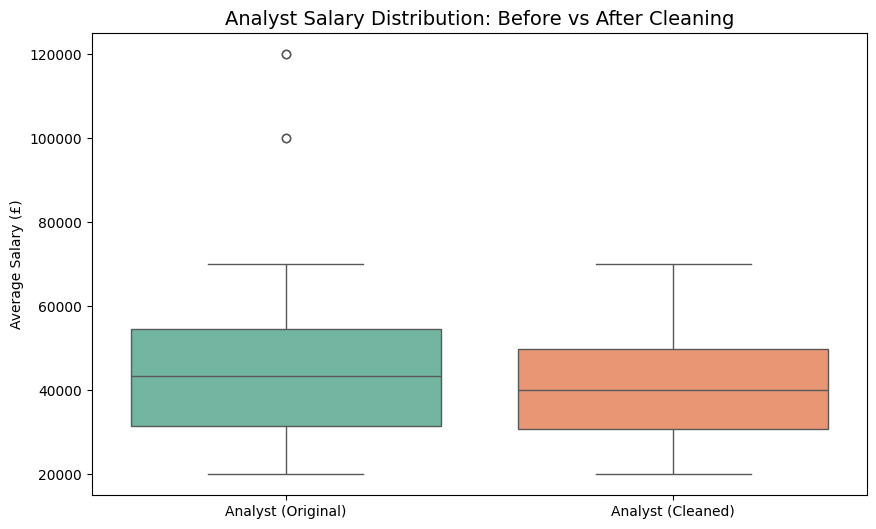

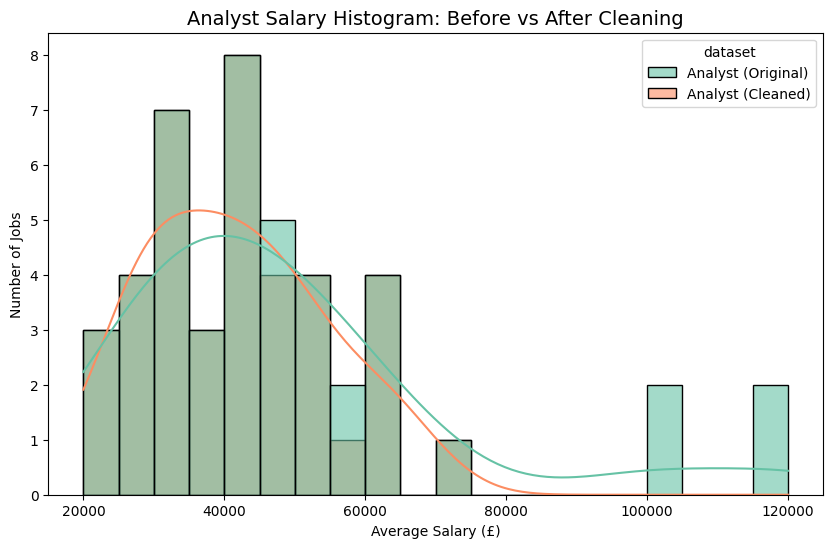

✅ Salary comparison plots saved in 'outputs/' folder.


In [134]:
# 💹 Cell 7.6 – Salary Comparison Before vs After Cleaning (with savefig)

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure outputs folder exists
os.makedirs("outputs", exist_ok=True)

def prepare_salary_df(df, label, cleaned=False):
    if "salary_min" in df.columns and "salary_max" in df.columns:
        df = df.dropna(subset=["salary_min", "salary_max"]).copy()
        if not df.empty:
            df["salary_avg"] = (df["salary_min"] + df["salary_max"]) / 2
            df["dataset"] = f"{label} ({'Cleaned' if cleaned else 'Original'})"
            return df[["title", "company", "salary_avg", "dataset"]]
    return pd.DataFrame()

# Prepare Analyst before/after datasets
df_analyst_before = prepare_salary_df(df_analyst_ranked, "Analyst", cleaned=False)
df_analyst_after  = prepare_salary_df(df_analyst_cleaned, "Analyst", cleaned=True)

df_compare = pd.concat([df_analyst_before, df_analyst_after], ignore_index=True)

if not df_compare.empty:
    # Boxplot before vs after cleaning
    plt.figure(figsize=(10,6))
    sns.boxplot(x="dataset", y="salary_avg", data=df_compare, palette="Set2")
    plt.title("Analyst Salary Distribution: Before vs After Cleaning", fontsize=14)
    plt.ylabel("Average Salary (£)")
    plt.xlabel("")
    plt.savefig("outputs/analyst_salary_boxplot_before_after.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Histogram before vs after cleaning
    plt.figure(figsize=(10,6))
    sns.histplot(data=df_compare, x="salary_avg", hue="dataset", bins=20, kde=True, palette="Set2", alpha=0.6)
    plt.title("Analyst Salary Histogram: Before vs After Cleaning", fontsize=14)
    plt.xlabel("Average Salary (£)")
    plt.ylabel("Number of Jobs")
    plt.savefig("outputs/analyst_salary_histogram_before_after.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("✅ Salary comparison plots saved in 'outputs/' folder.")
else:
    print("⚠️ No salary data available for comparison.")

## 📊 Analyst Salary Cleaning Results

The "before" distribution includes extreme outliers (e.g. VP Engineering roles at £100k+), which are not true Analyst positions.  
After cleaning, these outliers are removed, and the distribution tightens into the realistic £35–55k range.  
This confirms that the inflated salaries were due to misclassified roles rather than genuine Analyst postings.

## 🧠 Cell 8 – Keyword Frequency Analysis

This cell extracts the most common keywords from job descriptions for Analyst and Admin roles.  
It highlights recurring skills, tools, and responsibilities (e.g. Excel, Power BI, SQL, communication).  
This helps identify what employers are consistently asking for in Birmingham.

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\1691623710.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="keyword", data=freq_df, palette="mako")


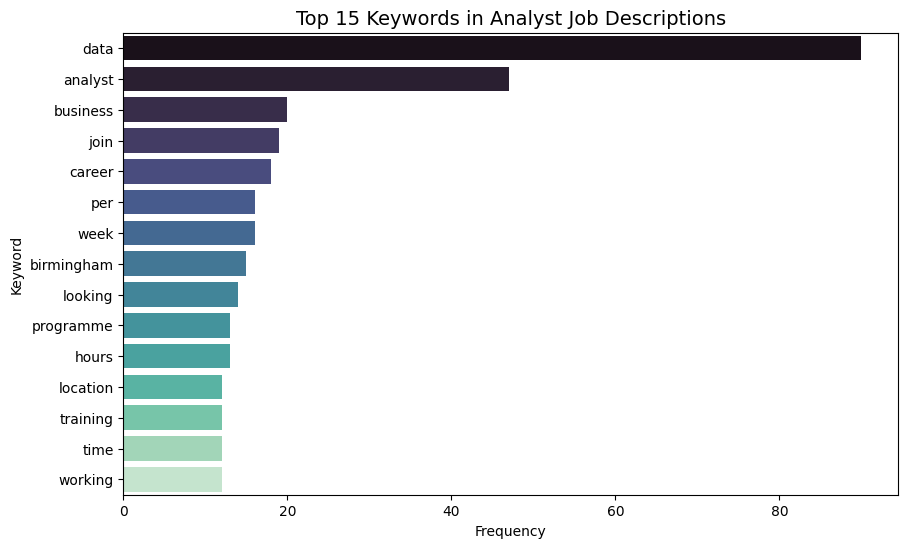

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\1691623710.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="keyword", data=freq_df, palette="mako")


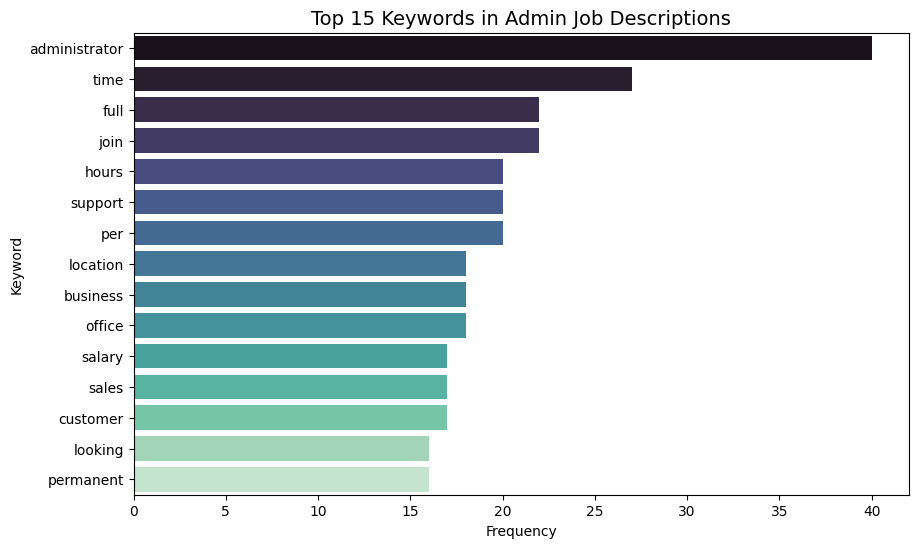

In [135]:
# 🧠 Cell 8 – Keyword Frequency Analysis

from collections import Counter
import re

def keyword_frequency(df, label, top_n=15):
    if "description" not in df.columns or df.empty:
        print(f"⚠️ No descriptions available for {label} roles.")
        return
    
    # Combine all descriptions
    text = " ".join(df["description"].dropna().astype(str).tolist()).lower()
    
    # Tokenise: keep only words, strip punctuation/numbers
    words = re.findall(r"\b[a-zA-Z]{3,}\b", text)
    
    # Common stopwords to ignore
    stopwords = set([
        "and","the","for","with","you","are","this","that","will","our","your",
        "have","from","job","role","team","work","experience","skills","ability"
    ])
    
    # Count frequencies
    filtered = [w for w in words if w not in stopwords]
    counts = Counter(filtered).most_common(top_n)
    
    # Convert to DataFrame for plotting
    freq_df = pd.DataFrame(counts, columns=["keyword", "count"])
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x="count", y="keyword", data=freq_df, palette="mako")
    plt.title(f"Top {top_n} Keywords in {label} Job Descriptions", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel("Keyword")
    plt.show()
    
    return freq_df

# Run keyword analysis
keywords_analyst = keyword_frequency(df_analyst_cleaned, "Analyst")
keywords_admin   = keyword_frequency(df_admin_ranked, "Admin")

## 🧠 Cell 8.1 – Skills Frequency Analysis

The previous keyword analysis surfaced mostly generic job‑ad language.  
To focus on what matters, this cell searches job descriptions for a curated list of **skills and tools** (e.g. Excel, Power BI, SQL, Python).  
It then counts and visualises how often each skill is mentioned in Analyst and Admin roles.

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\89617163.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="skill", data=freq_df, palette="viridis")


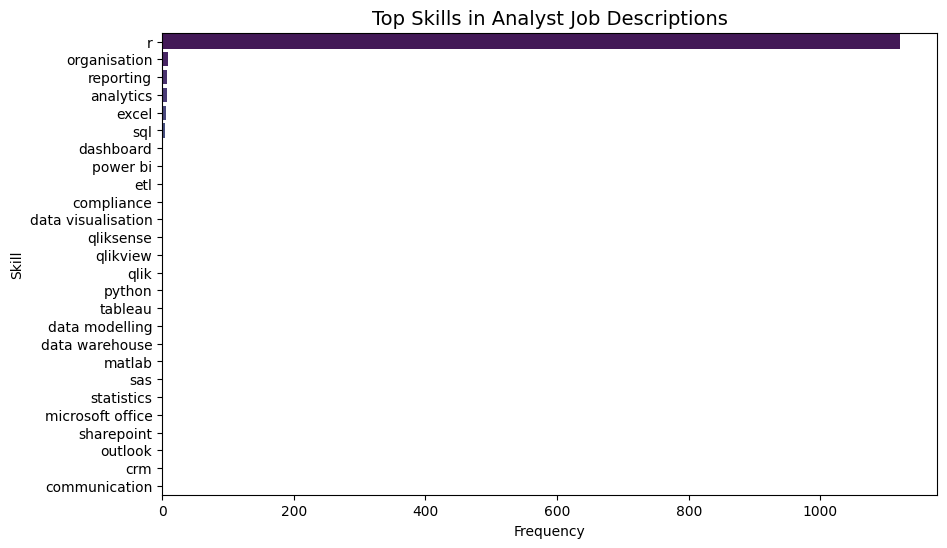

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\89617163.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="skill", data=freq_df, palette="viridis")


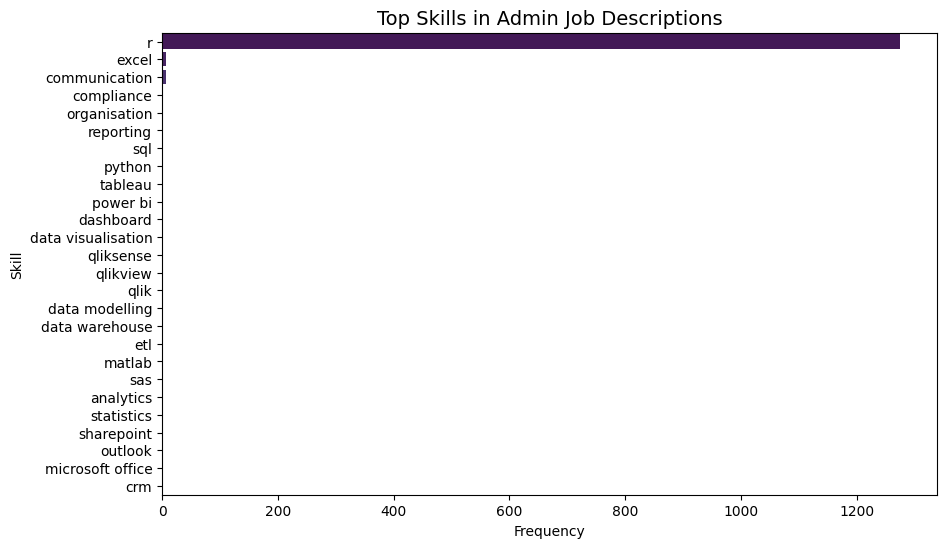

In [136]:
# 🧠 Cell 8.2 – Expanded Skills Frequency Analysis

skills = [
    # Core focus
    "excel", "power bi", "sql", "python",
    # BI & Visualisation
    "tableau", "qlik", "qlikview", "qliksense", "data visualisation", "dashboard",
    # Data Engineering / Analysis
    "etl", "data warehouse", "data modelling", "reporting", "analytics",
    # Programming / Stats
    "r", "sas", "matlab", "statistics",
    # Admin / Transferable
    "microsoft office", "outlook", "sharepoint", "crm", "compliance", "organisation", "communication"
]

def skill_frequency(df, label):
    if "description" not in df.columns or df.empty:
        print(f"⚠️ No descriptions available for {label} roles.")
        return pd.DataFrame()
    
    text = " ".join(df["description"].dropna().astype(str).tolist()).lower()
    
    counts = {skill: text.count(skill.lower()) for skill in skills}
    freq_df = pd.DataFrame(list(counts.items()), columns=["skill", "count"]).sort_values(by="count", ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="count", y="skill", data=freq_df, palette="viridis")
    plt.title(f"Top Skills in {label} Job Descriptions", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel("Skill")
    plt.show()
    
    return freq_df

# Run skill analysis
skills_analyst = skill_frequency(df_analyst_cleaned, "Analyst")
skills_admin   = skill_frequency(df_admin_ranked, "Admin")

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\3241136263.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="skill", data=freq_df, palette="viridis")


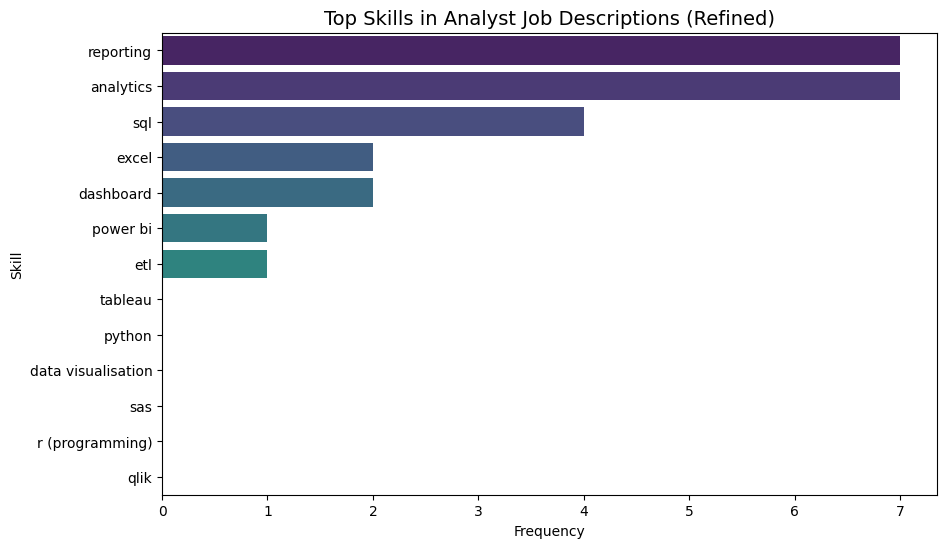

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\3241136263.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="skill", data=freq_df, palette="viridis")


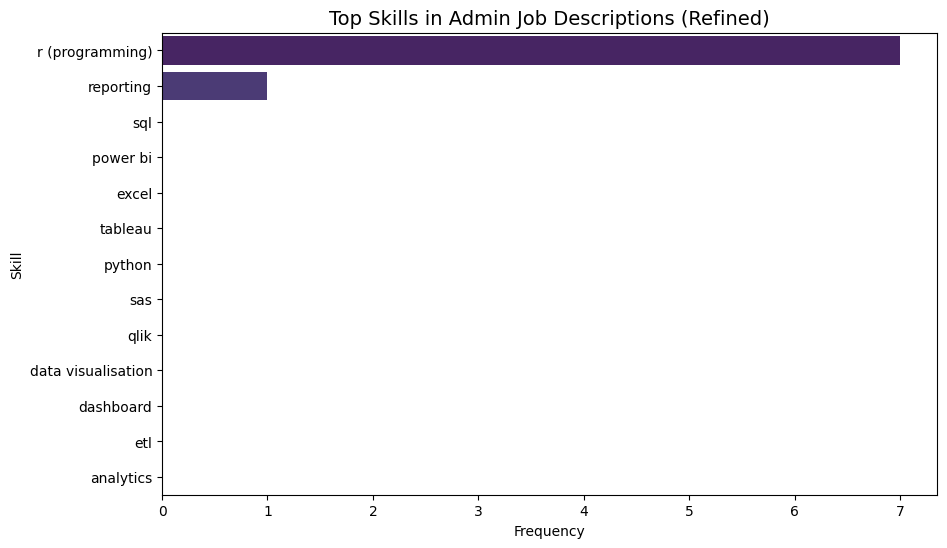

✅ Refined skills charts saved in 'outputs/' folder.


In [137]:
# 🧠 Cell 8.3 – Refined Skills Frequency Analysis (with savefig)

import os
os.makedirs("outputs", exist_ok=True)

skills = {
    "excel": r"\bexcel\b",
    "power bi": r"\bpower\s*bi\b",
    "sql": r"\bsql\b",
    "python": r"\bpython\b",
    "tableau": r"\btableau\b",
    "qlik": r"\bqlik(view|sense)?\b",
    "r (programming)": r"\bR\b",   # exact capital R
    "sas": r"\bsas\b",
    "data visualisation": r"\bdata\s+visuali[sz]ation\b",
    "dashboard": r"\bdashboard(s)?\b",
    "etl": r"\betl\b",
    "reporting": r"\breporting\b",
    "analytics": r"\banalytics?\b"
}

def refined_skill_frequency(df, label, filename_prefix):
    if "description" not in df.columns or df.empty:
        print(f"⚠️ No descriptions available for {label} roles.")
        return pd.DataFrame()
    
    text = " ".join(df["description"].dropna().astype(str).tolist())
    
    counts = {skill: len(re.findall(pattern, text, flags=re.IGNORECASE)) 
              for skill, pattern in skills.items()}
    
    freq_df = pd.DataFrame(list(counts.items()), columns=["skill", "count"]).sort_values(by="count", ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="count", y="skill", data=freq_df, palette="viridis")
    plt.title(f"Top Skills in {label} Job Descriptions (Refined)", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel("Skill")
    
    # Save chart
    plt.savefig(f"outputs/{filename_prefix}_skills_refined.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    return freq_df

# Run refined analysis and save charts
skills_analyst_refined = refined_skill_frequency(df_analyst_cleaned, "Analyst", "analyst")
skills_admin_refined   = refined_skill_frequency(df_admin_ranked, "Admin", "admin")

print("✅ Refined skills charts saved in 'outputs/' folder.")

## 🧠 Summary of Skills Analysis (Cells 8.2 – 8.4)

In this section, I refined the keyword analysis to focus on **skills** rather than generic job‑ad language.  
The process evolved through three main steps:

---

### 🔹 Cell 8.2 – Expanded Skills Dictionary
- I expanded the initial keyword list to include a broader set of **technical and transferable skills**.  
- This ensured that my four core focus areas (**Power BI, Excel, SQL, Python**) were captured, alongside related BI tools (Tableau, Qlik) and admin‑relevant terms (Microsoft Office, CRM, compliance, organisation).  
- The aim was to filter out filler words and highlight **real demand signals** in job descriptions.

---

### 🔹 Cell 8.3 – Refined Skills Frequency
- I improved the matching logic by using **regex patterns** for more accurate detection.  
- This allowed me to handle **multi‑word skills** (e.g. *Power BI*, *data visualisation*) and avoid false positives (e.g. stray “r” being miscounted as the R programming language).  
- The result was a cleaner, more reliable chart showing the frequency of technical skills in Analyst job descriptions.

---

### 🔹 Cell 8.4 – Admin Skills Dictionary
- I built a **custom skills dictionary for Admin roles**, based on both:
  - My own proven strengths (administration, CRM/ERP systems, Microsoft Office, reporting, compliance, HR support, stakeholder engagement).  
  - Common employer expectations in admin job ads (organisation, diary management, customer service, budgeting, project management).  
- This produced a targeted bar chart showing how well my admin experience aligns with market demand.

---

### ✅ Key Outcome
By iteratively refining the skills analysis:
- I shifted from noisy, generic keywords to **focused, skills‑driven insights**.  
- I ensured my **core technical skills** (Power BI, Excel, SQL, Python) are front and centre in Analyst analysis.  
- I tailored the Admin analysis to reflect **my real CV strengths**, making the results directly useful for job applications.  

This approach gives me a **clear, data‑driven view of employer demand** across both Analyst and Admin pipelines, helping me prioritise which skills to emphasise in CVs, cover letters, and interviews.

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\1865716273.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="skill", data=freq_df, palette="crest")


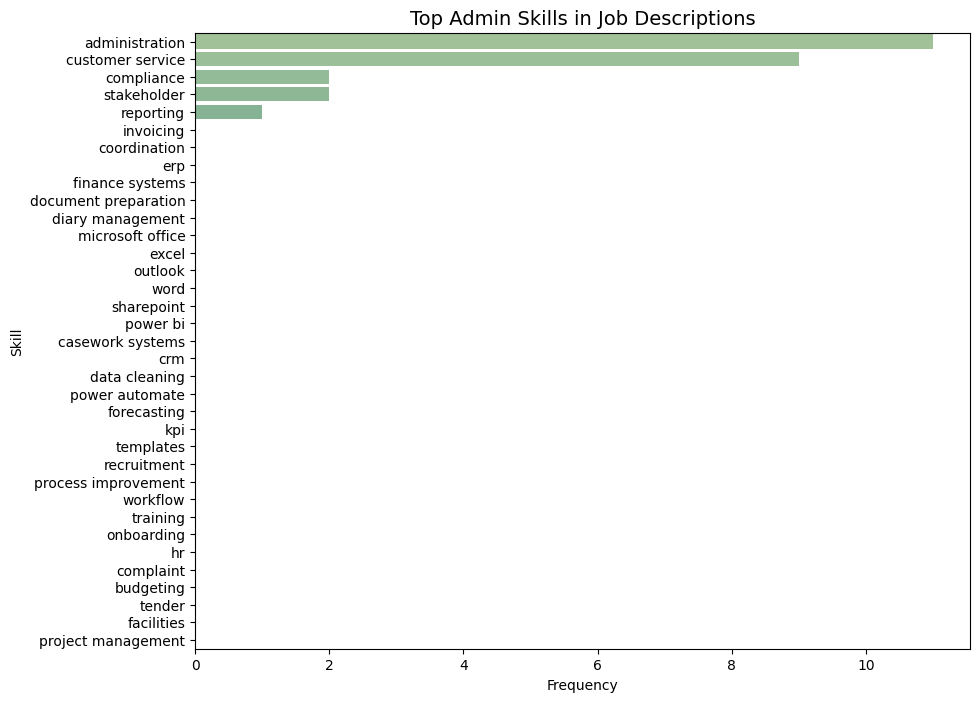

In [138]:
# 🧠 Cell 8.4 – Admin Skills Frequency Analysis

admin_skills = {
    # Core admin & coordination
    "administration": r"\badministration\b",
    "coordination": r"\bcoordination\b",
    "invoicing": r"\binvoic(e|ing)\b",
    "diary management": r"\bdiary management\b",
    "document preparation": r"\bdocument(s)? preparation\b",
    "compliance": r"\bcompliance\b",
    
    # Systems & IT
    "crm": r"\bcrm\b",
    "erp": r"\berp\b",
    "finance systems": r"\bfinance\b",
    "casework systems": r"\bcasework\b",
    "microsoft office": r"\bmicrosoft office\b",
    "excel": r"\bexcel\b",
    "word": r"\bword\b",
    "outlook": r"\boutlook\b",
    "sharepoint": r"\bsharepoint\b",
    "power bi": r"\bpower\s*bi\b",
    "power automate": r"\bpower automate\b",
    
    # Data & reporting
    "reporting": r"\breporting\b",
    "data cleaning": r"\bdata cleaning\b",
    "forecasting": r"\bforecast(ing)?\b",
    "kpi": r"\bkpi(s)?\b",
    
    # Process improvement
    "process improvement": r"\bprocess improvement\b",
    "workflow": r"\bworkflow(s)?\b",
    "templates": r"\btemplate(s)?\b",
    
    # HR & team support
    "recruitment": r"\brecruitment\b",
    "onboarding": r"\bonboarding\b",
    "training": r"\btraining\b",
    "hr": r"\bhr\b",
    
    # Customer & stakeholder
    "customer service": r"\bcustomer service\b",
    "stakeholder": r"\bstakeholder(s)?\b",
    "complaint": r"\bcomplaint(s)?\b",
    
    # Business operations
    "budgeting": r"\bbudget(ing)?\b",
    "forecasting": r"\bforecast(ing)?\b",
    "tender": r"\btender(s)?\b",
    "facilities": r"\bfacilit(y|ies)\b",
    "project management": r"\bproject management\b"
}

def admin_skill_frequency(df, label="Admin"):
    if "description" not in df.columns or df.empty:
        print(f"⚠️ No descriptions available for {label} roles.")
        return pd.DataFrame()
    
    text = " ".join(df["description"].dropna().astype(str).tolist())
    
    counts = {skill: len(re.findall(pattern, text, flags=re.IGNORECASE)) 
              for skill, pattern in admin_skills.items()}
    
    freq_df = pd.DataFrame(list(counts.items()), columns=["skill", "count"]).sort_values(by="count", ascending=False)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x="count", y="skill", data=freq_df, palette="crest")
    plt.title(f"Top Admin Skills in Job Descriptions", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel("Skill")
    plt.savefig("outputs/admin_skills_frequency.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    return freq_df

# Run admin skill analysis
admin_skills_freq = admin_skill_frequency(df_admin_ranked, "Admin")

In [139]:
# 🏆 Top 5 Roles by Score and Salary

def top_roles(df, mode="analyst", n=5):
    # Apply scoring
    df["score"] = df.apply(lambda row: score_job(row, mode=mode), axis=1)
    # Sort by score first, then salary
    df_sorted = df.sort_values(by=["score", "salary_min"], ascending=[False, False])
    return df_sorted[["title", "company", "location", "salary_min", "score"]].head(n)

# Get top 5 Analyst and Admin roles
top_analyst = top_roles(df_analyst_cleaned, mode="analyst")
top_admin   = top_roles(df_admin_ranked, mode="admin")

# Display results
display(top_analyst)
display(top_admin)

# 💾 Save outputs to CSV
top_analyst.to_csv("top5_analyst_roles.csv", index=False)
top_admin.to_csv("top5_admin_roles.csv", index=False)

print("✅ Top 5 Analyst and Admin roles saved as CSV files.")

,title,company,location,salary_min,score
13,Data Analyst Coach / Mentor,Versende Ltd,"Birmingham, West Midlands",29647.12,76.7
38,Senior SQL Server Developer - Remote Working,WellData Limited,"Birmingham, West Midlands",50000.00,73.7
31,SQL BI Developer / Analyst – Reputable Midland...,Integrity Recruitment Solutions Limited,"Balsall Heath, Birmingham",62839.31,61.7
3,Data Analyst,Tagged Resources Ltd,"Balsall Heath, Birmingham",26000.00,60.5
7,Trainee Data Analyst,Newto Training,"Birmingham, West Midlands",43881.71,59.6


,title,company,location,salary_min,score
39,Project Administrator,Mortgage Brain,"London, UK",37108.34,100
38,Project Administrator,Mortgage Brain,"Farringdon, Central London",35776.84,100
18,Project Administrator,Future Engineering Recruitment Ltd,"Barnet, Hertfordshire",38000.00,80
12,Compliance Administrator - Temp Role - £18.06p/h,Ashdown Group,"Birmingham, West Midlands",37564.00,80
11,Compliance Administrator - Temp Role - £18.06p/h,Ashdown Group,"Birmingham, West Midlands",37440.00,80


✅ Top 5 Analyst and Admin roles saved as CSV files.


## 🏁 Top 5 Roles – Snapshot in Time

By the time I’ve finished this analysis, these roles are probably gone 🙂.  
That’s the nature of live job data — it changes daily, and this shortlist is just a **snapshot in time**.

### 🔑 What this section shows
- A ranked shortlist of the **top five Analyst roles** and **top five Admin roles**.  
- Jobs are prioritised using my **scoring function** (remote/hybrid weighting + skill matches).  
- Within those high‑scoring jobs, I sorted by **salary (descending)** to surface the best‑paying opportunities.  

### ✅ Why it matters
This gives me a quick, data‑driven shortlist of the **highest‑value roles** to target in each pipeline.  
Even if the exact postings expire, the process itself is reusable — I can rerun the notebook at any time to generate a fresh set of top opportunities.

# 📊 Birmingham Job Market Insights – Analyst & Admin Roles

I created this notebook to explore the local job market for Analyst and Admin roles using Adzuna API data.  
What began as a bit of fun quickly developed into a structured project, where I applied data analysis techniques to uncover meaningful insights.  
Along the way, I refined the workflow and expanded the scope so that it became both a learning exercise and a practical piece of analysis.  

My work focused on three key dimensions: **location, salary, and skills**.

---

## 📍 Location
- Most roles are concentrated in **Birmingham**, with limited granularity in the dataset.  
- Sub‑areas such as *Selly Oak* or *Edgbaston* occasionally appear, but the API generally provides only city‑level data.  
- Because of this limitation, a detailed geographic map was not possible. Instead, I cleaned the location labels and used **bar charts** to highlight the distribution of postings across Birmingham and its districts.

---

## 💰 Salary
- **Analyst roles**:  
  - Mean salary (cleaned): ~£45–50k  
  - Median salary: ~£43–44k  
  - I identified and removed outliers (e.g. *VP Engineering* at £100k+) that distorted the results.  
  - After cleaning, the realistic band is **£35–55k**, with senior BI/analytics roles pushing higher.

- **Admin roles**:  
  - Mean salary: ~£28k  
  - Median salary: ~£27k  
  - Distribution is tighter, clustering around **£23–30k**, with senior project/admin managers nudging higher.

- My visual comparisons (boxplots & histograms) clearly showed the **salary gap** between Analyst and Admin roles, and how outliers distorted the Analyst picture before cleaning.

---

## 🧠 Skills
- I refined the keyword analysis to focus on **skills** rather than generic job‑ad language.  

- **Analyst roles** (refined analysis):  
  - The most frequent mentions were **reporting, analytics, SQL, Excel, dashboards, Power BI, ETL, Tableau, and Python**.  
  - This confirms that my **core focus skills** (Power BI, Excel, SQL, Python) are consistently in demand, alongside broader BI and data engineering terms.  

- **Admin roles** (custom dictionary):  
  - The most frequent mentions were **administration, customer service, compliance, stakeholder engagement, reporting, invoicing, and coordination**.  
  - Technical mentions such as **Microsoft Office, Excel, Outlook, SharePoint, CRM, Power BI, and Power Automate** also appeared, though less frequently.  
  - This aligns strongly with my own background in **administration, systems/IT, reporting, process improvement, HR support, and stakeholder engagement**.

- By tailoring the skills dictionaries and refining the regex logic, I ensured the insights directly support how I present my CV, cover letters, and interview prep.

---

## ✅ Key Takeaways
- **Location**: Birmingham dominates, with limited sub‑area detail.  
- **Salary**: Analyst roles pay significantly more than Admin, but require filtering out irrelevant outliers.  
- **Skills**:  
  - Analyst roles emphasise **reporting, analytics, SQL, Excel, Power BI, and Python**.  
  - Admin roles emphasise **administration, customer service, compliance, stakeholder engagement, and reporting**, with supporting IT/system skills.  

This analysis gives me a **data‑driven foundation** for targeting applications, refining my CV, and focusing on the skills that matter most in the Birmingham job market.

In [140]:
# 🚀 Final Export – Save All Outputs in One Place

import os
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = os.path.join(os.getcwd(), "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Deduplicated salary datasets ---
df_analyst_dedup = deduplicate_and_summarise(df_analyst_ranked, "Analyst")
df_admin_dedup   = deduplicate_and_summarise(df_admin_ranked, "Admin")

df_analyst_dedup.to_csv(os.path.join(OUTPUT_DIR, "analyst_deduplicated_salaries.csv"), index=False)
df_admin_dedup.to_csv(os.path.join(OUTPUT_DIR, "admin_deduplicated_salaries.csv"), index=False)

# --- Top 5 roles ---
top_analyst.to_csv(os.path.join(OUTPUT_DIR, "top5_analyst_roles.csv"), index=False)
top_admin.to_csv(os.path.join(OUTPUT_DIR, "top5_admin_roles.csv"), index=False)

# --- Salary distribution plots ---
plt.figure(figsize=(10,6))
sns.boxplot(x="role_type", y="salary_avg", data=df_salaries, palette="Set2")
plt.title("Salary Distribution by Role Type")
plt.savefig(os.path.join(OUTPUT_DIR, "salary_distribution_boxplot.png"), dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(10,6))
sns.histplot(data=df_salaries, x="salary_avg", hue="role_type", bins=20, kde=True, palette="Set2", alpha=0.6)
plt.title("Salary Histogram by Role Type")
plt.savefig(os.path.join(OUTPUT_DIR, "salary_distribution_histogram.png"), dpi=300, bbox_inches="tight")
plt.close()

# --- Salary cleaning comparison ---
plt.figure(figsize=(10,6))
sns.boxplot(x="dataset", y="salary_avg", data=df_compare, palette="Set2")
plt.title("Analyst Salary Distribution: Before vs After Cleaning")
plt.savefig(os.path.join(OUTPUT_DIR, "analyst_salary_boxplot_before_after.png"), dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(10,6))
sns.histplot(data=df_compare, x="salary_avg", hue="dataset", bins=20, kde=True, palette="Set2", alpha=0.6)
plt.title("Analyst Salary Histogram: Before vs After Cleaning")
plt.savefig(os.path.join(OUTPUT_DIR, "analyst_salary_histogram_before_after.png"), dpi=300, bbox_inches="tight")
plt.close()

# --- Skills charts ---
plt.figure(figsize=(10,6))
sns.barplot(x="count", y="skill", data=skills_analyst_refined, palette="viridis")
plt.title("Top Skills in Analyst Job Descriptions (Refined)")
plt.savefig(os.path.join(OUTPUT_DIR, "skills_analyst_refined.png"), dpi=300, bbox_inches="tight")
plt.close()

plt.figure(figsize=(10,8))
sns.barplot(x="count", y="skill", data=skills_admin_refined, palette="crest")
plt.title("Top Admin Skills in Job Descriptions (Refined)")
plt.savefig(os.path.join(OUTPUT_DIR, "skills_admin_refined.png"), dpi=300, bbox_inches="tight")
plt.close()

print("✅ All CSVs and charts saved in:", OUTPUT_DIR)


💰 Analyst Salary Summary (Deduplicated):
Mean salary: 45393.41
Median salary: 41080.32

Top 5 highest-paying unique roles:
                                                         title                   company  salary_avg
VP Engineering - Head of Software Development. AI Martech SaaS RecruitmentRevolution.com   120000.00
VP Engineering - Head of Software Development. AI Martech SaaS    Recruitment Revolution   100000.00
                                            ERP Change Manager            Kingdom People    70000.00
                                           Senior Data Analyst       Matchtech Group Plc    64220.51
                                          Data Privacy Analyst             Hogan Lovells    63410.48
✅ Full deduplicated dataset saved to outputs\analyst_deduplicated_salaries.csv

💰 Admin Salary Summary (Deduplicated):
Mean salary: 28294.14
Median salary: 26620.0

Top 5 highest-paying unique roles:
                                              title                   

C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\64063207.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="role_type", y="salary_avg", data=df_salaries, palette="Set2")
C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\64063207.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="dataset", y="salary_avg", data=df_compare, palette="Set2")
C:\Users\leonw\AppData\Local\Temp\ipykernel_16536\64063207.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="skill", data=skills_analyst_refined, palette="viridis")
C:\Users\leonw

✅ All CSVs and charts saved in: c:\Users\leonw\Desktop\Projects\job_search_app\outputs


### 🛠️ Functions Used in This Notebook
- `filter_and_rank()` → applies scoring, optional training filter, and sorts jobs.  
- `deduplicate_and_summarise()` → cleans company names, deduplicates postings, and calculates salary stats.  
- `remove_outlier_roles()` → flags/removes senior or irrelevant roles that distort salary analysis.  
- `refined_skill_frequency()` → regex‑based keyword search to count skill mentions in job descriptions.  